In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import re
import json
from collections import defaultdict
import os
from evaluate_flipflop import get_base_accuracy, get_digit_accuracy, get_relaxed_distance_accuracy, get_strict_distance_accuracy, get_per_dist_accuracy

In [45]:
def get_data(path):
    with open(path, 'r') as file:
        data = [json.loads(line) for line in file]
    return data

In [46]:
def get_of_length(length, path):
    data = get_data(path)

    flipflop_of_length = []
    for line in data:
        if len(line['flipflop']) == length:
            flipflop_of_length.append(line)

    return flipflop_of_length

In [47]:
# could have just taken lengths and positions from the file name but oh well
def count_custom_length(input_string):
    # Define keywords and their lengths
    keywords = ["write", "read", "ignore"]
    keyword_length = 1

    i = 0
    total_length = 0

    while i < len(input_string):
        # Check if the substring matches any of the keywords
        matched = False
        for keyword in keywords:
            if input_string[i:i+len(keyword)] == keyword:
                total_length += keyword_length
                i += len(keyword)
                matched = True
                break

        # If no keyword matches, check if it's a digit
        if not matched:
            if input_string[i].isdigit():
                total_length += 1
                i += 1
            else:
                print(input_string[i])
                raise ValidationError("This should not be the case")

    return total_length

In [48]:
def find_last_write_idx(input_string):
    pattern = r'(write|read|ignore)([01])'
    
    matches = re.findall(pattern, input_string)
    
    result = []
    for action, number in matches:
        result.append(action)
        result.append(number)

    for i in range(len(result)-1, -1, -1):
        if result[i] == "write":
            return i

## Sparse Llama results - w and r probability of 0.1

Loaded 250 entries from all folders.


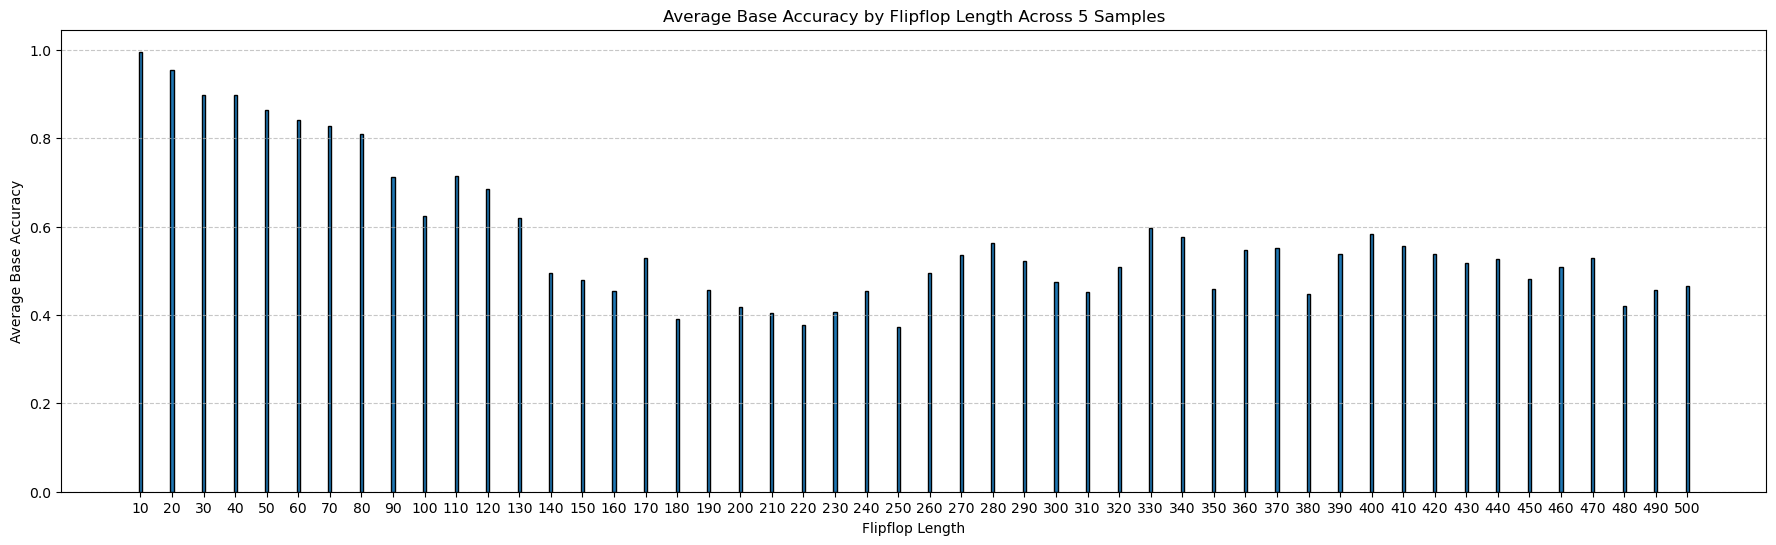

In [49]:
# average over 5 samples

# List of folders to process
folders = ["llama3.3_70B-instruct/sparse-worded/s1", 
           "llama3.3_70B-instruct/sparse-worded/s2", 
           "llama3.3_70B-instruct/sparse-worded/s3", 
           "llama3.3_70B-instruct/sparse-worded/s4", 
           "llama3.3_70B-instruct/sparse-worded/s5"]

all_samples_llama = []

# Iterate over all folders and load data
for folder_path in folders:
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jsonl"):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                one_sample_data = []
                for line in file:
                    one_sample = json.loads(line)
                    one_sample_data.append(one_sample)
                all_samples_llama.append(one_sample_data)

print(f"Loaded {len(all_samples_llama)} entries from all folders.")

# Aggregate accuracies by sparse length across all folders
acc_by_length = defaultdict(list)

for result in all_samples_llama:
    acc = get_base_accuracy(result)
    length = count_custom_length(result[0]['flipflop'])
    acc_by_length[length].append(acc)

# Calculate average accuracy for each sparse length
average_acc_by_length = {length: sum(accs) / len(accs) for length, accs in acc_by_length.items()}

# Reverse sort and display results
sorted_acc = dict(sorted(average_acc_by_length.items(), key=lambda item: item[0], reverse=False))
for length in sorted_acc.keys():
    pass
    #print(f'Average base accuracy for sparse length {length} is {sorted_acc[length]:.2f}')

# Plot the results
lengths = list(sorted_acc.keys())
average_accuracies = list(sorted_acc.values())

plt.figure(figsize=(22, 6))
plt.bar(lengths, average_accuracies, width=1, align='center', edgecolor='black')
plt.xlabel("Flipflop Length")
plt.ylabel("Average Base Accuracy")
plt.title("Average Base Accuracy by Flipflop Length Across 5 Samples")
plt.xticks(lengths) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

#plt.show()


Loaded 250 entries from all folders.


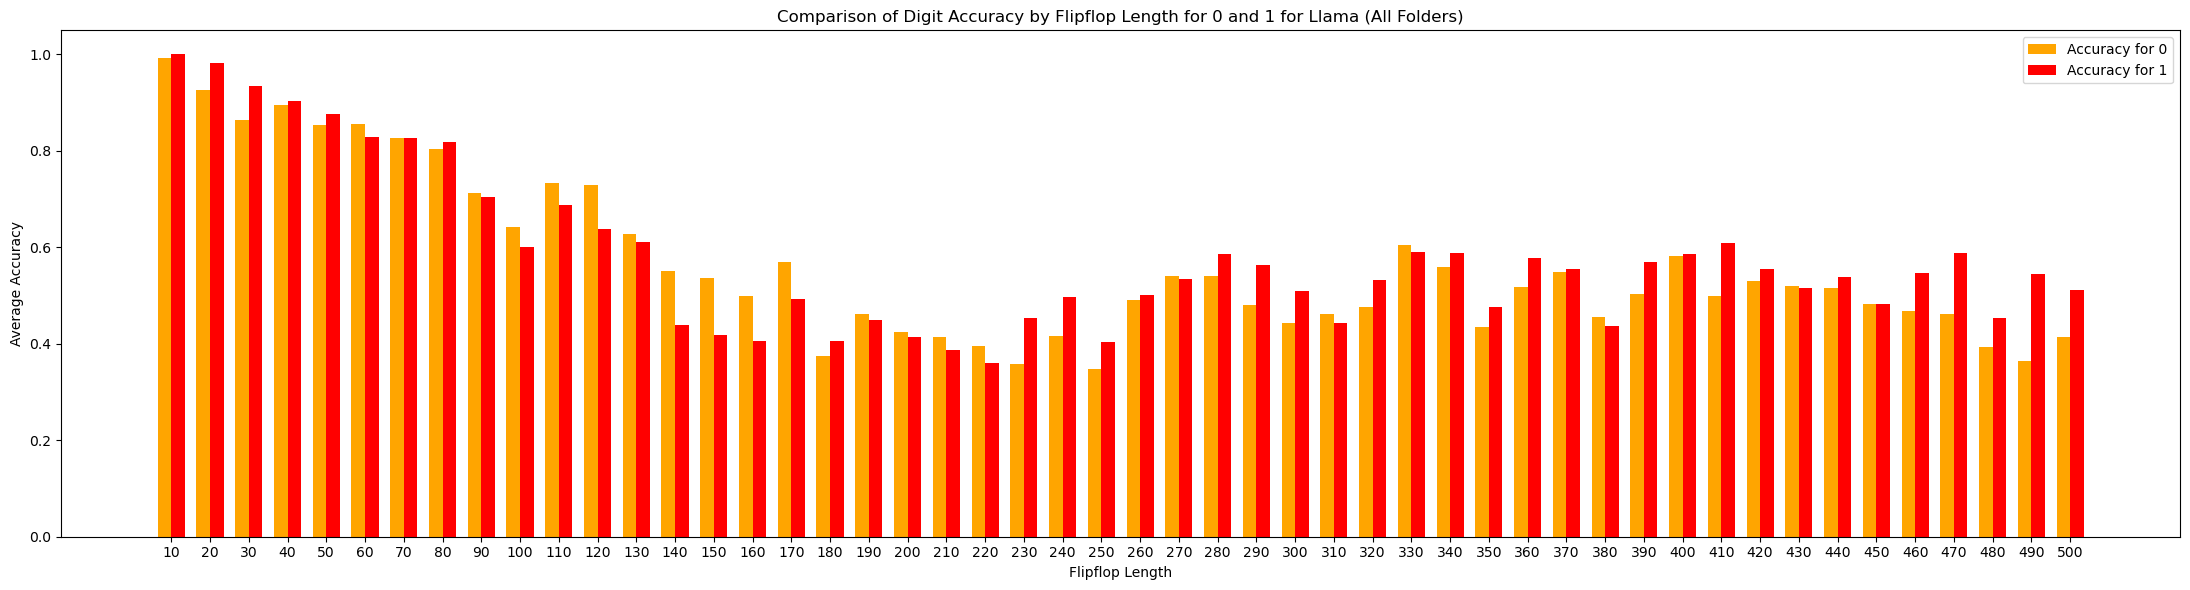

In [50]:
folders = ["llama3.3_70B-instruct/sparse-worded/s1", 
           "llama3.3_70B-instruct/sparse-worded/s2", 
           "llama3.3_70B-instruct/sparse-worded/s3", 
           "llama3.3_70B-instruct/sparse-worded/s4", 
           "llama3.3_70B-instruct/sparse-worded/s5"]

all_samples_llama = []

# Load data from all folders
for folder_path in folders:
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jsonl"):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                one_sample_data = []
                for line in file:
                    one_sample = json.loads(line)
                    one_sample_data.append(one_sample)
                all_samples_llama.append(one_sample_data)

print(f"Loaded {len(all_samples_llama)} entries from all folders.")

# Group accuracies by flipflop length for digits 0 and 1
length_acc_1 = defaultdict(list)
length_acc_0 = defaultdict(list)

for result in all_samples_llama:
    length = count_custom_length(result[0]['flipflop'])
    acc_1 = get_digit_accuracy(result, 1)
    acc_0 = get_digit_accuracy(result, 0)
    length_acc_1[length].append(acc_1)
    length_acc_0[length].append(acc_0)

# Compute average accuracies for each length
sorted_lengths = sorted(length_acc_1.keys())

avg_acc_1 = []
avg_acc_0 = []

for length in sorted_lengths:
    avg_acc_1.append(sum(length_acc_1[length]) / len(length_acc_1[length]))
    avg_acc_0.append(sum(length_acc_0[length]) / len(length_acc_0[length]))

# Plotting
bar_width = 0.35
indices = np.arange(len(sorted_lengths))

plt.figure(figsize=(22, 6))
plt.bar(indices - bar_width / 2, avg_acc_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, avg_acc_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Flipflop Length")
plt.ylabel("Average Accuracy")
plt.title("Comparison of Digit Accuracy by Flipflop Length for 0 and 1 for Llama (All Folders)")
plt.xticks(indices, sorted_lengths)
plt.legend()

plt.tight_layout()
plt.show()

# Sparse OLMo results - w and r probability of 0.1

Loaded 250 entries from all folders.


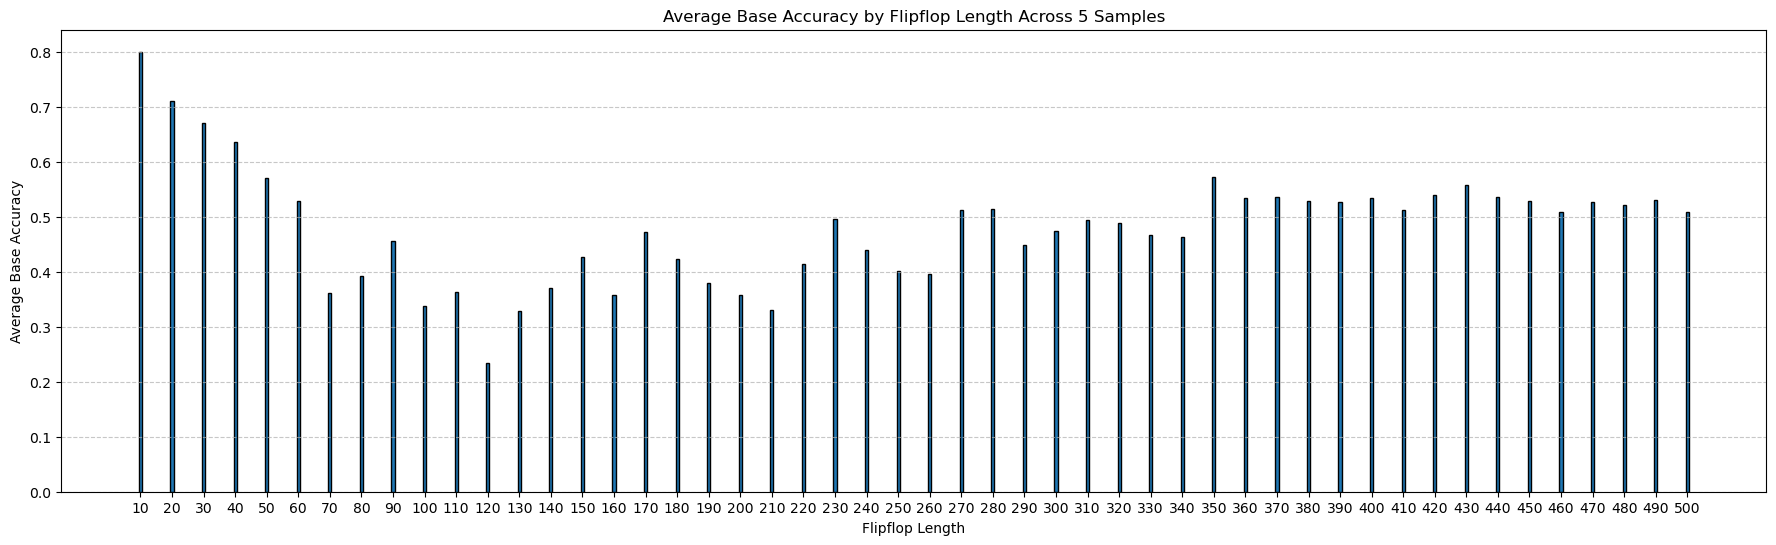

In [51]:
# average over 5 samples

# List of folders to process
folders = ["OLMo_7B-instruct/sparse-worded/s1", 
           "OLMo_7B-instruct/sparse-worded/s2", 
           "OLMo_7B-instruct/sparse-worded/s3", 
           "OLMo_7B-instruct/sparse-worded/s4", 
           "OLMo_7B-instruct/sparse-worded/s5"]

all_samples_olmo = []

# Iterate over all folders and load data
for folder_path in folders:
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jsonl"):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                one_sample_data = []
                for line in file:
                    one_sample = json.loads(line)
                    one_sample_data.append(one_sample)
                all_samples_olmo.append(one_sample_data)

print(f"Loaded {len(all_samples_olmo)} entries from all folders.")

# Aggregate accuracies by sparse length across all folders
acc_by_length = defaultdict(list)

for result in all_samples_olmo:
    acc = get_base_accuracy(result)
    length = count_custom_length(result[0]['flipflop'])
    acc_by_length[length].append(acc)

# Calculate average accuracy for each sparse length
average_acc_by_length = {length: sum(accs) / len(accs) for length, accs in acc_by_length.items()}

# Reverse sort and display results
sorted_acc = dict(sorted(average_acc_by_length.items(), key=lambda item: item[0], reverse=False))
for length in sorted_acc.keys():
    pass
    #print(f'Average base accuracy for sparse length {length} is {sorted_acc[length]:.2f}')

# Plot the results
lengths = list(sorted_acc.keys())
average_accuracies = list(sorted_acc.values())

plt.figure(figsize=(22, 6))
plt.bar(lengths, average_accuracies, width=1, align='center', edgecolor='black')
plt.xlabel("Flipflop Length")
plt.ylabel("Average Base Accuracy")
plt.title("Average Base Accuracy by Flipflop Length Across 5 Samples")
plt.xticks(lengths) 
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()


Loaded 250 entries from all folders.


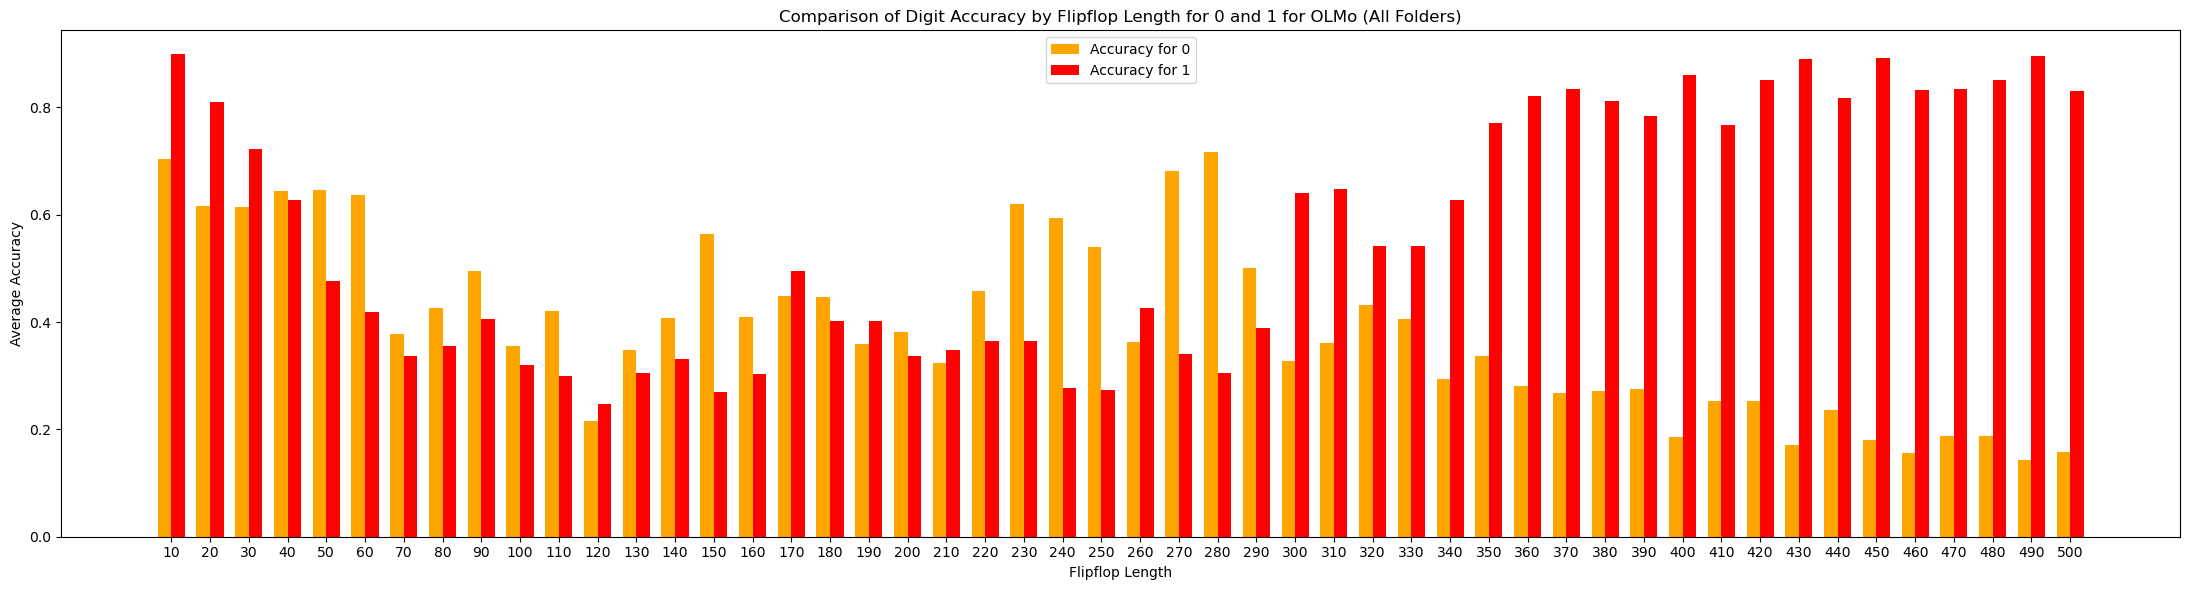

In [52]:
folders = ["OLMo_7B-instruct/sparse-worded/s1", 
           "OLMo_7B-instruct/sparse-worded/s2", 
           "OLMo_7B-instruct/sparse-worded/s3", 
           "OLMo_7B-instruct/sparse-worded/s4", 
           "OLMo_7B-instruct/sparse-worded/s5"]

all_samples_olmo = []

# Load data from all folders
for folder_path in folders:
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jsonl"):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                one_sample_data = []
                for line in file:
                    one_sample = json.loads(line)
                    one_sample_data.append(one_sample)
                all_samples_olmo.append(one_sample_data)

print(f"Loaded {len(all_samples_llama)} entries from all folders.")

# Group accuracies by flipflop length for digits 0 and 1
length_acc_1 = defaultdict(list)
length_acc_0 = defaultdict(list)

for result in all_samples_olmo:
    length = count_custom_length(result[0]['flipflop'])
    acc_1 = get_digit_accuracy(result, 1)
    acc_0 = get_digit_accuracy(result, 0)
    length_acc_1[length].append(acc_1)
    length_acc_0[length].append(acc_0)

# Compute average accuracies for each length
sorted_lengths = sorted(length_acc_1.keys())

avg_acc_1 = []
avg_acc_0 = []

for length in sorted_lengths:
    avg_acc_1.append(sum(length_acc_1[length]) / len(length_acc_1[length]))
    avg_acc_0.append(sum(length_acc_0[length]) / len(length_acc_0[length]))

# Plotting
bar_width = 0.35
indices = np.arange(len(sorted_lengths))

plt.figure(figsize=(22, 6))
plt.bar(indices - bar_width / 2, avg_acc_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, avg_acc_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Flipflop Length")
plt.ylabel("Average Accuracy")
plt.title("Comparison of Digit Accuracy by Flipflop Length for 0 and 1 for OLMo (All Folders)")
plt.xticks(indices, sorted_lengths)
plt.legend()

plt.tight_layout()
plt.show()

# Llama and OLMo per distance to last write

## Distance Llama results

Loaded 295 entries from all folders.


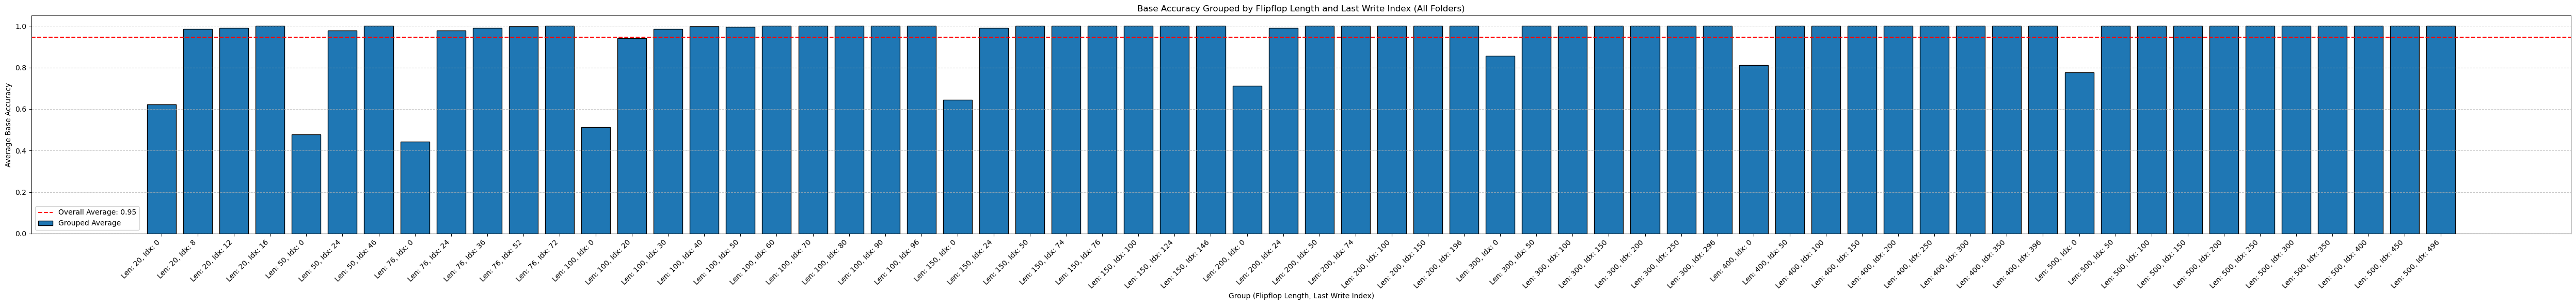

In [61]:
folders = ["llama3.1_70B/distance-worded/s1", 
           "llama3.1_70B/distance-worded/s2", 
           "llama3.1_70B/distance-worded/s3", 
           "llama3.1_70B/distance-worded/s4", 
           "llama3.1_70B/distance-worded/s5"]

all_data_llama = []

# Load data from all folders
for folder_path in folders:
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jsonl"):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                one_sample_data = []
                for line in file:
                    one_sample = json.loads(line)
                    one_sample_data.append(one_sample)
                all_data_llama.append(one_sample_data)

print(f"Loaded {len(all_data_llama)} entries from all folders.")

# Group accuracies by length and last_write_index
grouped_accuracies = defaultdict(list)

for result in all_data_llama:
    acc = get_base_accuracy(result)
    length = count_custom_length(result[0]['flipflop'])
    idx = find_last_write_idx(result[0]['flipflop'])
    grouped_accuracies[(length, idx)].append(acc)

# Aggregate and sort data
grouped_results = {}
for (length, idx), accuracies in grouped_accuracies.items():
    avg_acc = sum(accuracies) / len(accuracies)  # Average accuracy for the group
    grouped_results[(length, idx)] = avg_acc

# Calculate overall average accuracy across all data
all_accuracies = [acc for accuracies in grouped_accuracies.values() for acc in accuracies]
overall_avg_accuracy = sum(all_accuracies) / len(all_accuracies)

# Sort by length and last_write_index
sorted_grouped_results = dict(sorted(grouped_results.items(), key=lambda x: (x[0][0], x[0][1])))

# Prepare data for plotting
x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in sorted_grouped_results.keys()]
accuracies = list(sorted_grouped_results.values())

# Plot grouped results for all folders
plt.figure(figsize=(50, 6))
plt.bar(x_labels, accuracies, width=0.8, align='center', edgecolor='black', label="Grouped Average")
plt.axhline(y=overall_avg_accuracy, color='red', linestyle='--', label=f"Overall Average: {overall_avg_accuracy:.2f}")
plt.xlabel("Group (Flipflop Length, Last Write Index)")
plt.ylabel("Average Base Accuracy")
plt.title("Base Accuracy Grouped by Flipflop Length and Last Write Index (All Folders)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

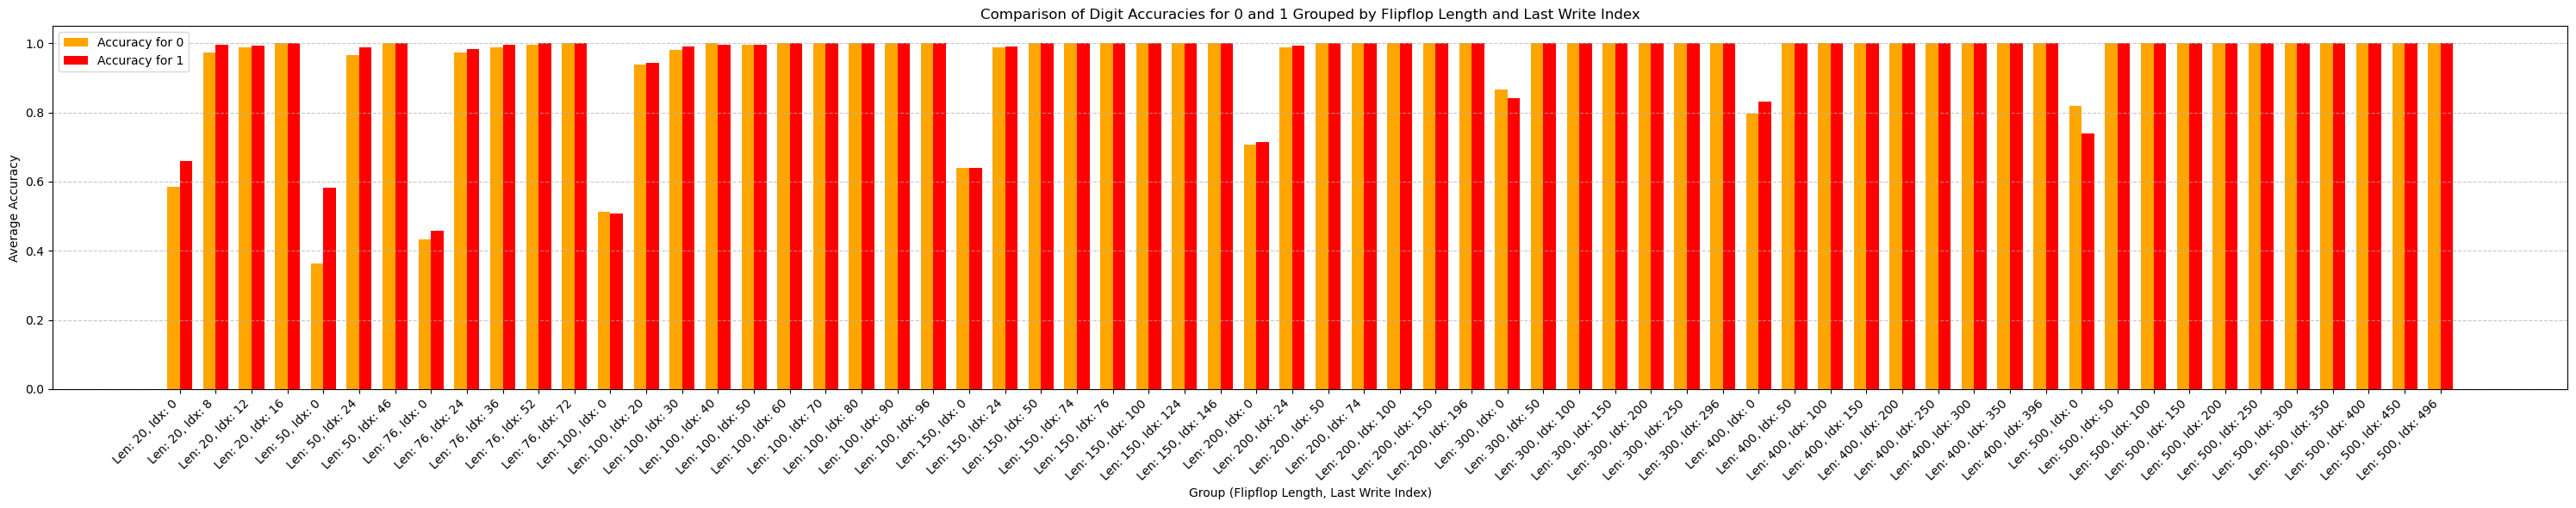

In [62]:
grouped_digit_accuracies_0 = defaultdict(list)
for result in all_data_llama:
    length = count_custom_length(result[0]['flipflop'])
    dist = find_last_write_idx(result[0]['flipflop'])
    acc = get_digit_accuracy(result, 0)
    grouped_digit_accuracies_0[(length, dist)].append(acc)

grouped_results_0 = {k: sum(v) / len(v) for k, v in grouped_digit_accuracies_0.items()}
sorted_grouped_results_0 = dict(sorted(grouped_results_0.items(), key=lambda x: (x[0][0], x[0][1])))

# Group and calculate accuracies for digit 1
grouped_digit_accuracies_1 = defaultdict(list)
for result in all_data_llama:
    length = count_custom_length(result[0]['flipflop'])
    dist = find_last_write_idx(result[0]['flipflop'])
    acc = get_digit_accuracy(result, 1)
    grouped_digit_accuracies_1[(length, dist)].append(acc)

grouped_results_1 = {k: sum(v) / len(v) for k, v in grouped_digit_accuracies_1.items()}
sorted_grouped_results_1 = dict(sorted(grouped_results_1.items(), key=lambda x: (x[0][0], x[0][1])))

# Prepare data for plotting
x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in sorted_grouped_results_0.keys()]
accuracies_0 = [sorted_grouped_results_0[k] for k in sorted_grouped_results_0.keys()]
accuracies_1 = [sorted_grouped_results_1[k] for k in sorted_grouped_results_0.keys()]  # Match keys for comparison

# Plot
bar_width = 0.35
indices = np.arange(len(x_labels))

plt.figure(figsize=(30, 6))
plt.bar(indices - bar_width / 2, accuracies_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, accuracies_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Group (Flipflop Length, Last Write Index)")
plt.ylabel("Average Accuracy")
plt.title("Comparison of Digit Accuracies for 0 and 1 Grouped by Flipflop Length and Last Write Index")
plt.xticks(indices, x_labels, rotation=45, ha="right")
plt.legend()

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


## Distance OLMo results

Loaded 295 entries from all folders.


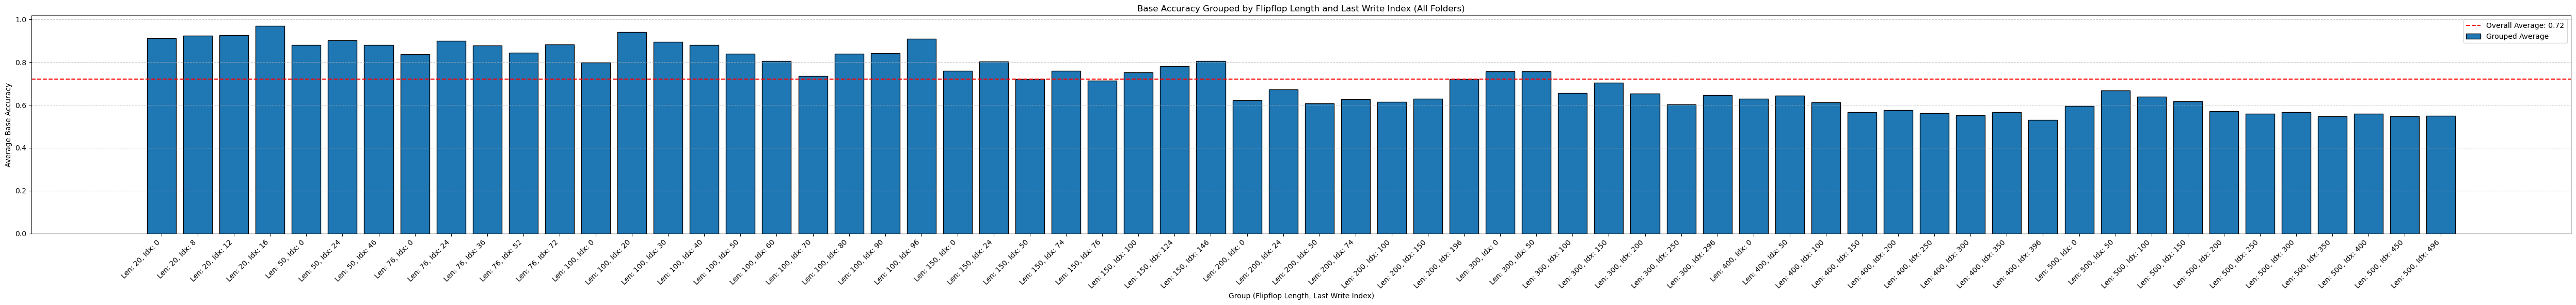

In [64]:
folders = ["OLMo_7B-/distance-worded/s1", 
           "OLMo_7B/distance-worded/s2", 
           "OLMo_7B/distance-worded/s3", 
           "OLMo_7B/distance-worded/s4", 
           "OLMo_7B/distance-worded/s5"]

all_samples_olmo = []

# Load data from all folders
for folder_path in folders:
    for file_name in os.listdir(folder_path):
        if file_name.endswith(".jsonl"):
            file_path = os.path.join(folder_path, file_name)
            with open(file_path, 'r', encoding='utf-8') as file:
                one_sample_data = []
                for line in file:
                    one_sample = json.loads(line)
                    one_sample_data.append(one_sample)
                all_samples_olmo.append(one_sample_data)

print(f"Loaded {len(all_samples_olmo)} entries from all folders.")

# Group accuracies by length and last_write_index
grouped_accuracies = defaultdict(list)

for result in all_samples_olmo:
    acc = get_base_accuracy(result)
    length = count_custom_length(result[0]['flipflop'])
    idx = find_last_write_idx(result[0]['flipflop'])
    grouped_accuracies[(length, idx)].append(acc)

# Aggregate and sort data
grouped_results = {}
for (length, idx), accuracies in grouped_accuracies.items():
    avg_acc = sum(accuracies) / len(accuracies)  # Average accuracy for the group
    grouped_results[(length, idx)] = avg_acc

# Calculate overall average accuracy across all data
all_accuracies = [acc for accuracies in grouped_accuracies.values() for acc in accuracies]
overall_avg_accuracy = sum(all_accuracies) / len(all_accuracies)

# Sort by length and last_write_index
sorted_grouped_results = dict(sorted(grouped_results.items(), key=lambda x: (x[0][0], x[0][1])))

# Prepare data for plotting
x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in sorted_grouped_results.keys()]
accuracies = list(sorted_grouped_results.values())

# Plot grouped results for all folders
plt.figure(figsize=(50, 6))
plt.bar(x_labels, accuracies, width=0.8, align='center', edgecolor='black', label="Grouped Average")
plt.axhline(y=overall_avg_accuracy, color='red', linestyle='--', label=f"Overall Average: {overall_avg_accuracy:.2f}")
plt.xlabel("Group (Flipflop Length, Last Write Index)")
plt.ylabel("Average Base Accuracy")
plt.title("Base Accuracy Grouped by Flipflop Length and Last Write Index (All Folders)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.legend()

plt.tight_layout()
plt.show()

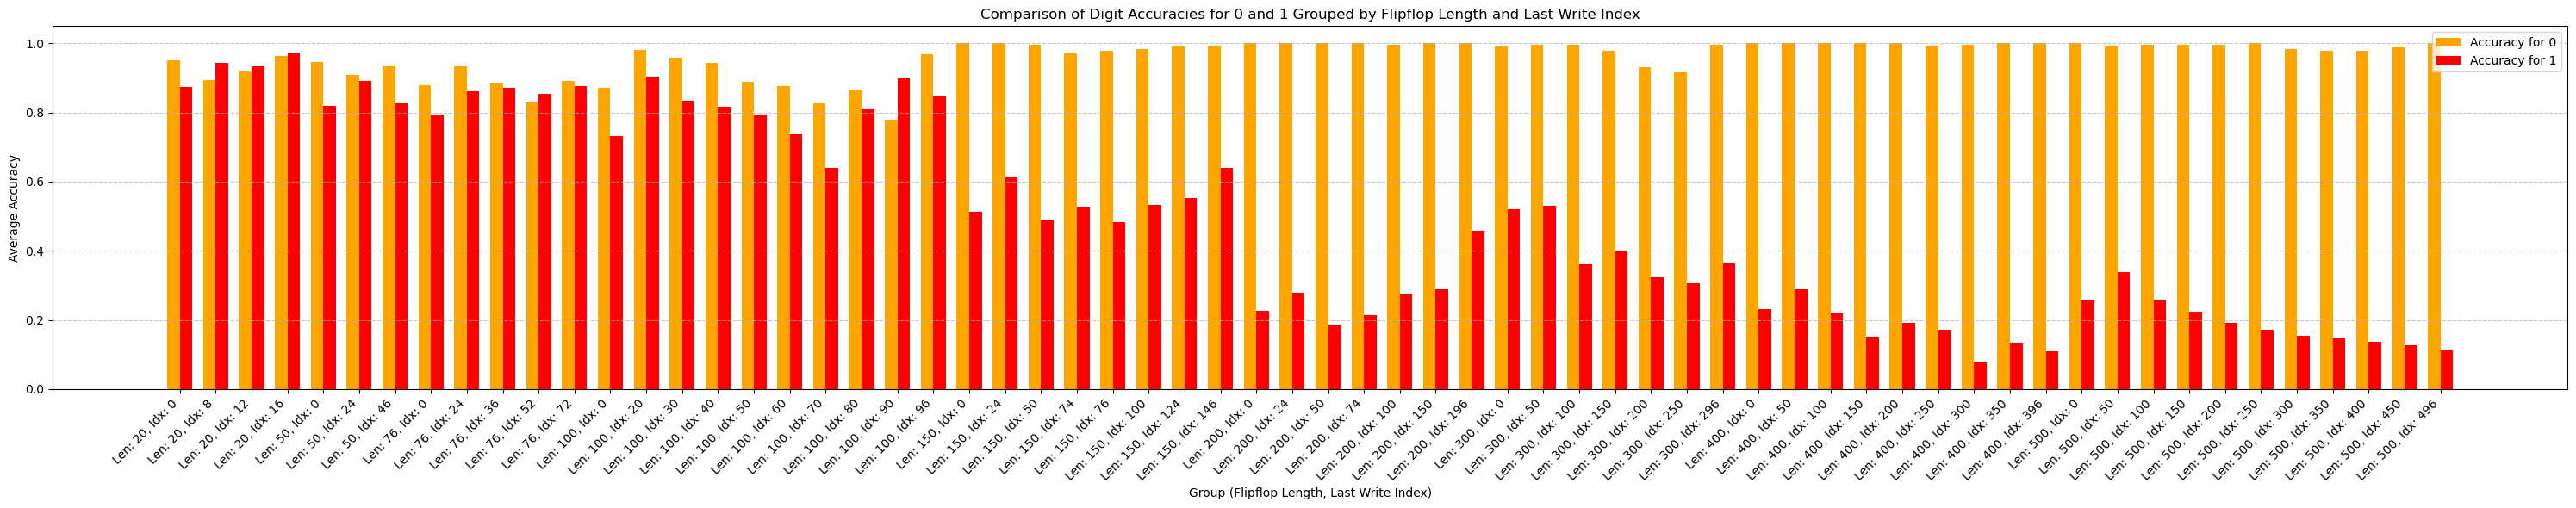

In [66]:
grouped_digit_accuracies_0 = defaultdict(list)
for result in all_samples_olmo:
    length = count_custom_length(result[0]['flipflop'])
    dist = find_last_write_idx(result[0]['flipflop'])
    acc = get_digit_accuracy(result, 0)
    grouped_digit_accuracies_0[(length, dist)].append(acc)

grouped_results_0 = {k: sum(v) / len(v) for k, v in grouped_digit_accuracies_0.items()}
sorted_grouped_results_0 = dict(sorted(grouped_results_0.items(), key=lambda x: (x[0][0], x[0][1])))

# Group and calculate accuracies for digit 1
grouped_digit_accuracies_1 = defaultdict(list)
for result in all_samples_olmo:
    length = count_custom_length(result[0]['flipflop'])
    dist = find_last_write_idx(result[0]['flipflop'])
    acc = get_digit_accuracy(result, 1)
    grouped_digit_accuracies_1[(length, dist)].append(acc)

grouped_results_1 = {k: sum(v) / len(v) for k, v in grouped_digit_accuracies_1.items()}
sorted_grouped_results_1 = dict(sorted(grouped_results_1.items(), key=lambda x: (x[0][0], x[0][1])))

# Prepare data for plotting
x_labels = [f"Len: {k[0]}, Idx: {k[1]}" for k in sorted_grouped_results_0.keys()]
accuracies_0 = [sorted_grouped_results_0[k] for k in sorted_grouped_results_0.keys()]
accuracies_1 = [sorted_grouped_results_1[k] for k in sorted_grouped_results_0.keys()]  # Match keys for comparison

# Plot
bar_width = 0.35
indices = np.arange(len(x_labels))

plt.figure(figsize=(30, 6))
plt.bar(indices - bar_width / 2, accuracies_0, bar_width, label="Accuracy for 0", color='orange')
plt.bar(indices + bar_width / 2, accuracies_1, bar_width, label="Accuracy for 1", color='red')

plt.xlabel("Group (Flipflop Length, Last Write Index)")
plt.ylabel("Average Accuracy")
plt.title("Comparison of Digit Accuracies for 0 and 1 Grouped by Flipflop Length and Last Write Index")
plt.xticks(indices, x_labels, rotation=45, ha="right")
plt.legend()

plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()